Epochs: 20000
Batch size: 128


W0813 07:48:11.798479 139894597543808 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0813 07:48:13.392128 139894597543808 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


0 [D loss: 0.693796, acc.: 30.08%] [G loss: 0.679444]


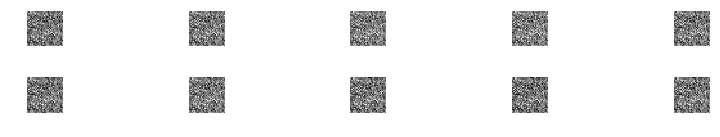

5000 [D loss: 0.693936, acc.: 53.52%] [G loss: 0.738524]


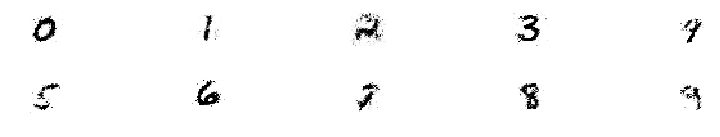

10000 [D loss: 0.685177, acc.: 51.95%] [G loss: 0.739518]


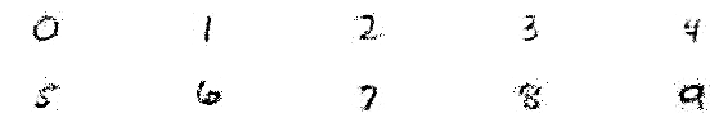

15000 [D loss: 0.690365, acc.: 48.05%] [G loss: 0.737710]


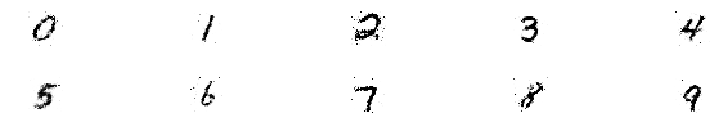

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Dense, Activation, Reshape, LeakyReLU, Flatten
from tensorflow.keras.layers import BatchNormalization, multiply, Embedding, Dropout


class CGAN():
    def __init__(self):
        self.width = 28
        self.height = 28
        self.channels = 1
        self.img_shape = (self.width, self.height, self.channels)
        self.num_classes = 10
        self.z_dim = 100

        self.adam = Adam(0.0002, 0.5)
        
        self.generator = self.Build_Generator()

        self.discriminator = self.Build_Discriminator()
        self.discriminator.compile(loss = ['binary_crossentropy'], optimizer = self.adam, metrics = ['accuracy'])
        self.discriminator.trainable = False

        noise = Input(shape = (self.z_dim,))
        label = Input(shape = (1,))
        img = self.generator([noise, label])
        valid = self.discriminator([img, label])

        self.combined = keras.Model([noise, label], valid)
        self.combined.compile(loss = ['binary_crossentropy'], optimizer = self.adam)

        
    def Build_Generator(self):
        model = keras.Sequential(
        [
            Dense(256, input_dim=self.z_dim),
            LeakyReLU(alpha=0.2),
            BatchNormalization(momentum=0.8),
            Dense(512),
            LeakyReLU(alpha=0.2),
            BatchNormalization(momentum=0.8),
            Dense(1024),
            LeakyReLU(alpha=0.2),
            BatchNormalization(momentum=0.8),
            Dense(np.prod(self.img_shape), activation='tanh'),
            Reshape(self.img_shape)
        ])

        noise = Input(shape=(self.z_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.z_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return keras.Model([noise, label], img)

    
    def Build_Discriminator(self):
        model = keras.Sequential(
        [
            Dense(512, input_dim=np.prod(self.img_shape)),
            LeakyReLU(alpha=0.2),
            Dense(512),
            LeakyReLU(alpha=0.2),
            Dropout(0.4),
            Dense(512),
            LeakyReLU(alpha=0.2),
            Dropout(0.4),
            Dense(1, activation='sigmoid')
        ])

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return keras.Model([img, label], validity)
    
    
    def Plot_Generated(self, n_ex = 10, dim = (2, 5), figsize = (12, 2)):
        noise = np.random.normal(0, 1, size = (n_ex, self.z_dim))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)
        generated_images = self.generator.predict([noise, sampled_labels])
        generated_images = generated_images.reshape(generated_images.shape[0], self.width, self.height)
        plt.figure(figsize = figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i+1)
            plt.imshow(generated_images[i, :, :], interpolation = 'nearest', cmap = 'gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        

    def Train(self, epochs = 20000, plt_frq = 5000, batch_size = 128):
        print('Epochs:', epochs)
        print('Batch size:', batch_size)

        (X_train, y_train), (_, _) = keras.datasets.mnist.load_data()

        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.z_dim))
            gen_imgs = self.generator.predict([noise, labels])

            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.z_dim))
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if epoch%plt_frq == 0:
                print('-----------', 'Epoch %d' % epoch, '-----------')
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.Plot_Generated()


if __name__ == '__main__':
    cgan = CGAN()
    cgan.Train()